## Цель PCA:
Сжать (уменьшить размерность) данных при сохранении как можно большей части информации (дисперсии), выявив "главные направления" изменения данных.

## Пример:
Если у тебя есть 100 признаков, PCA позволяет представить данные в 2–3 измерениях, в которых они наиболее "варьируются", без сильной потери информации.

## Где применяется PCA
* Удаление шума
* Предобработка перед кластеризацией (KMeans, DBSCAN)
* Визуализация в 2D/3D
* Подготовка к классификации (например, в SVM)
* Снижение переобучения в high-dimensional данных

## Ограничения PCA
* ⚠️ Предполагает линейность
* ⚠️ Чувствителен к масштабу — обязательно нормализовать!
* ⚠️ Не подходит для категориальных признаков
* ⚠️ Плохо справляется с нелинейными зависимостями (здесь лучше t-SNE, UMAP)

# Есть 2 способа реализовать PCA

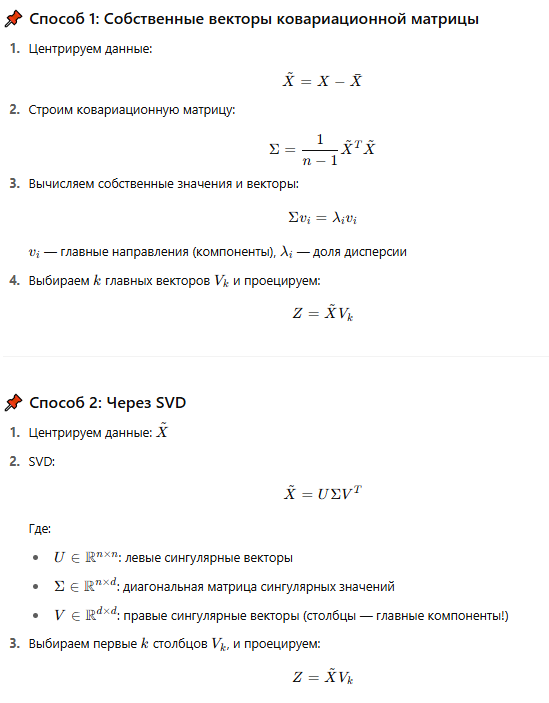

In [1]:
from IPython.display import Image
Image('eig_svd.png')

### Связь между SVD и ковариационной матрицей

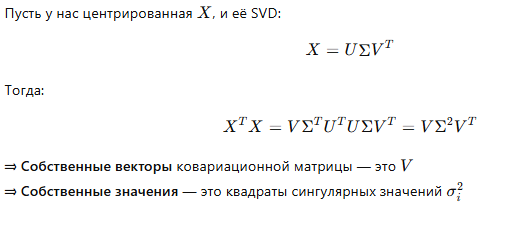

In [2]:
Image('link.png')

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

data = load_iris()
X = data.data  # Только числовые признаки
y = data.target  # Метки классов (для цвета в графике)

In [3]:
def center_data(X):
    return X - np.mean(X, axis=0)


In [24]:
def pca_eig(X, n_components=2):
    X_centered = center_data(X)
    
    # 1. Ковариационная матрица
    cov_matrix = np.cov(X_centered, rowvar=False)
    
    # 2. Собственные значения и векторы
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)  # eigh — симметричная матрица
    
    # 3. Сортируем по убыванию дисперсии
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    
    # 4. Выбираем k компонент
    components = eigenvectors[:, :n_components]
    
    # 5. Проекция
    X_reduced = X_centered @ components

    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)
    
    return X_reduced, explained_variance_ratio

In [25]:
def pca_svd(X, n_components=2):
    X_centered = center_data(X)
    
    # 1. SVD
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    
    # 2. Берем первые n_components столбцов V
    components = Vt[:n_components].T
    
    # 3. Проекция
    X_reduced = X_centered @ components
    
    explained_variance = (S ** 2) / (X_centered.shape[0] - 1)
    explained_variance_ratio = explained_variance[:n_components] / np.sum(explained_variance)
    
    return X_reduced, explained_variance_ratio


In [26]:
def plot_pca(X_reduced, title, y):
    plt.figure(figsize=(6, 5))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='viridis', edgecolor='k')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Explained Variance Ratio (eig): [0.00521218 0.01710261]
Explained Variance Ratio (svd): [0.92461872 0.05306648]


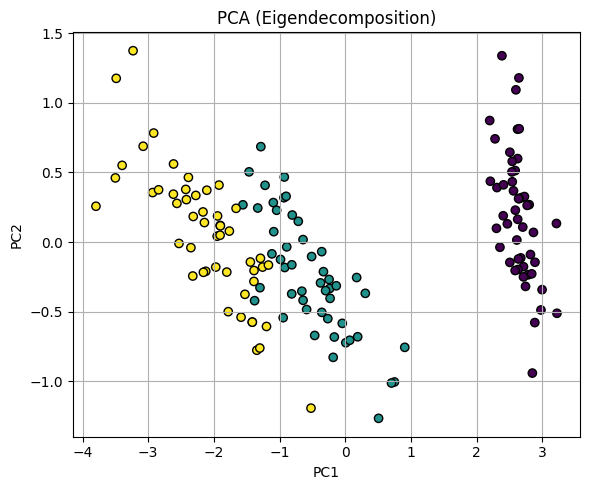

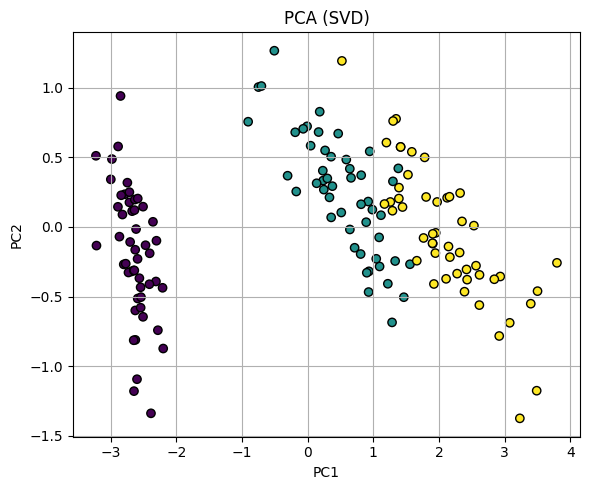

In [27]:
X_pca_eig, var_eig = pca_eig(X, 2)
X_pca_svd, var_svd = pca_svd(X, 2)

print("Explained Variance Ratio (eig):", var_eig)
print("Explained Variance Ratio (svd):", var_svd)
plot_pca(X_pca_eig, "PCA (Eigendecomposition)", y)
plot_pca(X_pca_svd, "PCA (SVD)", y)


In [10]:
diff = np.abs(X_pca_eig) - np.abs(X_pca_svd)
print("Макс разница между PCA по SVD и Eigen:", np.max(np.abs(diff)))


Макс разница между PCA по SVD и Eigen: 1.8561541192951836e-15


## Теперь я хочу
Написать функцию select_k_for_variance(X, method="eig", retain_variance=0.95), которая:
* принимает матрицу данных X
* Вычисляет PCA (через eig или svd)
* Возвращает:
    * k: минимальное количество компонент, достаточное для сохранения не менее retain_variance (например, 0.95)
    * X_reduced: проекция на эти k компонент
    * explained_variance_ratio: массив накопленных долей дисперсии

In [28]:
def select_k_for_variance(X, method="eig", retain_variance=0.95):
    X_centered = center_data(X)

    if method == "eig":
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]

        # Объясненная дисперсия
        total_variance = np.sum(eigenvalues)
        explained_variance_ratio = np.cumsum(eigenvalues) / total_variance

        # Сколько компонент нужно для retain_variance
        k = np.argmax(explained_variance_ratio >= retain_variance) + 1
        components = eigenvectors[:, :k]
        X_reduced = X_centered @ components

    elif method == "svd":
        U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
        explained_variance = (S ** 2) / (X_centered.shape[0] - 1)
        explained_variance_ratio = np.cumsum(explained_variance) / np.sum(explained_variance)

        k = np.argmax(explained_variance_ratio >= retain_variance) + 1
        components = Vt[:k].T
        X_reduced = X_centered @ components

    else:
        raise ValueError("Method must be 'eig' or 'svd'")

    return k, X_reduced, explained_variance_ratio


In [29]:
k_eig, X_reduced_eig, cum_var_eig = select_k_for_variance(X, method="eig", retain_variance=0.95)
k_svd, X_reduced_svd, cum_var_svd = select_k_for_variance(X, method="svd", retain_variance=0.95)

print(f"[EIG] Components to retain 95% variance: {k_eig}")
print(f"[SVD] Components to retain 95% variance: {k_svd}")


[EIG] Components to retain 95% variance: 2
[SVD] Components to retain 95% variance: 2


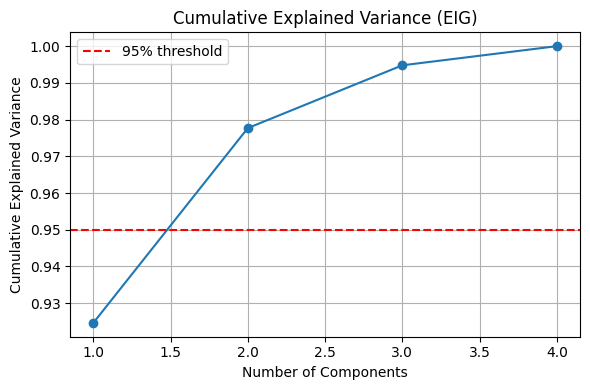

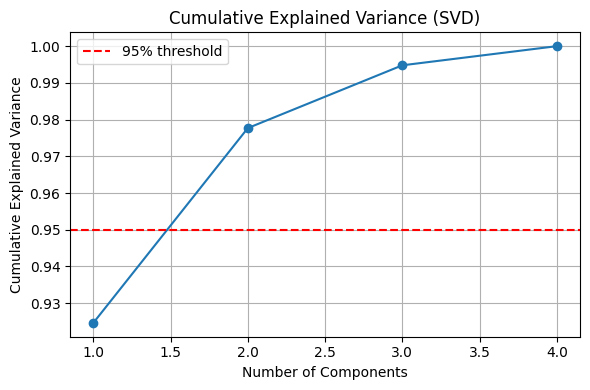

In [30]:
def plot_explained_variance(cumulative_ratios, method):
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(1, len(cumulative_ratios) + 1), cumulative_ratios, marker='o')
    plt.axhline(0.95, color='red', linestyle='--', label='95% threshold')
    plt.title(f'Cumulative Explained Variance ({method.upper()})')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_explained_variance(cum_var_eig, "eig")
plot_explained_variance(cum_var_svd, "svd")


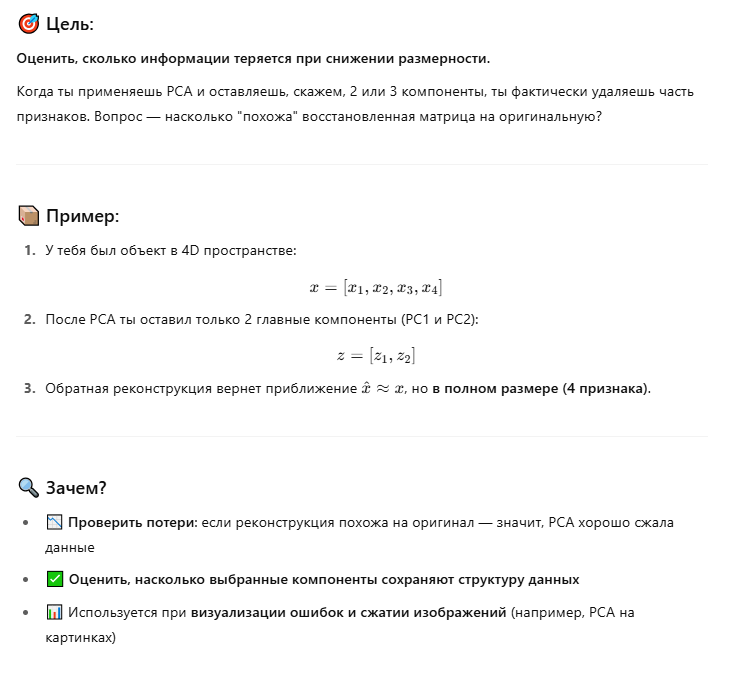

In [31]:
Image('inverse.png')

### Реализация обратной реконструкции
##### Формула (на центрированных данных):
* X = Z * W^T
  * Где:
Z — пониженное представление
W — матрица компонент (орты, главные направления) 
W^T — обратное преобразование

In [34]:
def reconstruct_pca(X_reduced, components, X_mean):
    """
    Восстанавливает оригинальные признаки из пониженного пространства PCA.
    """
    return X_reduced @ components.T + X_mean

def pca_eig_full(X, n_components=2):
    X_centered = center_data(X)
    mean = np.mean(X, axis=0)
    
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    components = eigenvectors[:, :n_components]
    X_reduced = X_centered @ components
    explained_variance_ratio = eigenvalues[:n_components] / np.sum(eigenvalues)

    return X_reduced, components, mean, explained_variance_ratio


In [38]:
def pca_svd_full(X, n_components=2):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    
    components = Vt[:n_components].T  # d x k
    X_reduced = X_centered @ components

    explained_variance = (S ** 2) / (X_centered.shape[0] - 1)
    explained_variance_ratio = explained_variance[:n_components] / np.sum(explained_variance)

    return X_reduced, components, X_mean, explained_variance_ratio


In [39]:
# Используем PCA через eig
X_red_eig, comp_eig, mean_eig, _ = pca_eig_full(X, 2)
X_rec_eig = reconstruct_pca(X_red_eig, comp_eig, mean_eig)

# Используем PCA через SVD
X_red_svd, comp_svd, mean_svd, _ = pca_svd_full(X, 2)
X_rec_svd = reconstruct_pca(X_red_svd, comp_svd, mean_svd)


In [40]:
from sklearn.metrics import mean_squared_error

mse_eig = mean_squared_error(X, X_rec_eig)
mse_svd = mean_squared_error(X, X_rec_svd)

print(f"MSE реконструкции через eig: {mse_eig:.6f}")
print(f"MSE реконструкции через svd: {mse_svd:.6f}")


MSE реконструкции через eig: 0.025341
MSE реконструкции через svd: 0.025341


## Преимущества:
* понижение размерности с сохранением большого количества информации, что также позволяет визуализировать данные высокой размерности в двумерном или трёхмерном пространстве;
* не только позволяет значительно ускорить обучение, но и уменьшить переобучение моделей в ряде случаев;
* может использоваться для сжатия данных.

## Недостатки:
* неизбежная потеря части информации в данных;
* поиск только линейной зависимости в данных (в обычном PCA);
* отсутствие смыслового значения главных компонент из-за трудности их связывания с реальными признакам.